In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable  
from matplotlib.colorbar import ColorbarBase
import folium
from folium.plugins import HeatMap
import geopandas as gpd

# EDA

Daten zum PV-Ausbau aus der SQLite-Datenbank einlesen

In [2]:
# SQLite Datenbank Pfad 
SQLITE_FILE_PATH = os.path.join("..", "output", "dwh.sqlite3")

In [3]:
# Connection zur Datenbank 
con = sqlite3.connect(SQLITE_FILE_PATH)

In [4]:
query_test = '''
SELECT *
FROM marktstammdaten
'''
marktstammdaten = pd.read_sql_query(query_test, con=con)
marktstammdaten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173010 entries, 0 to 3173009
Data columns (total 26 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   DatumLetzteAktualisierung                 object 
 1   NetzbetreiberpruefungStatus               int64  
 2   AnlagenbetreiberMastrNummer               object 
 3   Bundesland                                object 
 4   Landkreis                                 object 
 5   Gemeinde                                  object 
 6   AGS-8                                     object 
 7   Postleitzahl                              object 
 8   Ort                                       object 
 9   Registrierungsdatum                       object 
 10  Inbetriebnahmedatum                       object 
 11  EinheitBetriebsstatus                     object 
 12  Bruttoleistung                            float64
 13  FernsteuerbarkeitNb                       float64
 14  Ei

## PV-Anlagen pro Betreiber

In [5]:
query001 = '''
SELECT AnlagenbetreiberMastrNummer, COUNT(*) AS Anzahl_PV_Anlagen
FROM marktstammdaten
GROUP BY AnlagenbetreiberMastrNummer
'''
betreiber = pd.read_sql_query(query001, con=con)
#betreiber

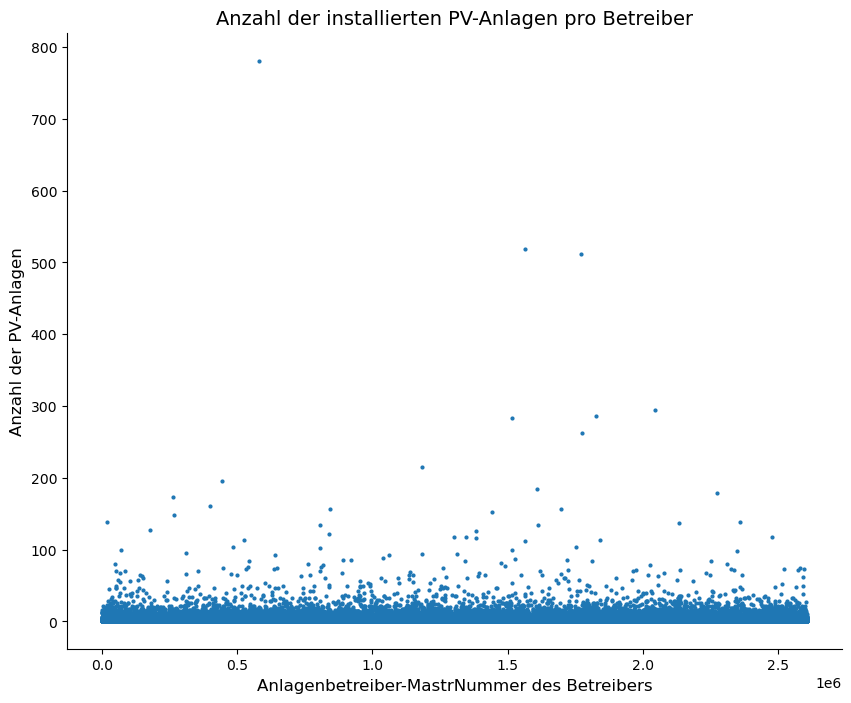

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(betreiber['Anzahl_PV_Anlagen'].values, marker='o', linestyle='', markersize=2)
plt.xlabel('Anlagenbetreiber-MastrNummer des Betreibers', fontsize=12)
plt.ylabel('Anzahl der PV-Anlagen', fontsize=12)
plt.title('Anzahl der installierten PV-Anlagen pro Betreiber', fontsize=14)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

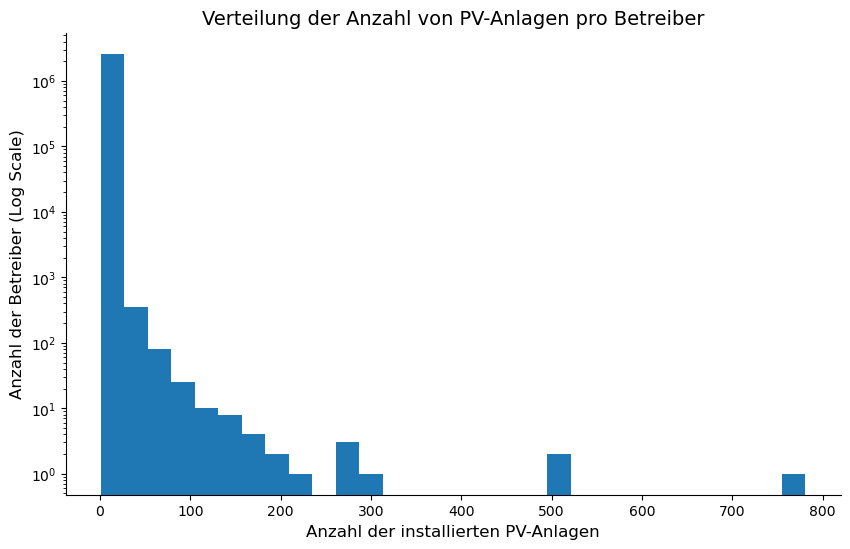

In [7]:
# Darstellung als Histogramm mit logarithmischer Skala, um die Extremwerte darzustellen
plt.figure(figsize=(10, 6))
plt.hist(betreiber['Anzahl_PV_Anlagen'], bins=30)
plt.yscale('log') 
plt.xlabel('Anzahl der installierten PV-Anlagen', fontsize=12)
plt.ylabel('Anzahl der Betreiber (Log Scale)', fontsize=12)
plt.title('Verteilung der Anzahl von PV-Anlagen pro Betreiber', fontsize=14)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [8]:
# TOP 20 Solaranlaen-Betreiber
query002 = '''
SELECT AnlagenbetreiberMastrNummer, COUNT(*) AS Anzahl_PV_Anlagen, [AGS-8], Bundesland
FROM marktstammdaten
GROUP BY AnlagenbetreiberMastrNummer
ORDER BY COUNT(*) DESC
'''
betreiber2 = pd.read_sql_query(query002, con=con)
betreiber2.head(20)

AnlagenbetreiberMastrNummer  Anzahl_PV_Anlagen     AGS-8  \
0              ABR922330502361                781  12065136   
1              ABR960080516405                519  14612000   
2              ABR967988325672                512  06412000   
3              ABR978541747770                295  08117026   
4              ABR970056665143                286  06412000   
5              ABR958136610962                284  07333038   
6              ABR968043089126                262  06635002   
7              ABR945486862196                215  05366040   
8              ABR917026309294                195  05315000   
9              ABR961772090289                184  16067091   
10             ABR987327906287                179  09162000   
11             ABR910056399693                173  16067067   
12             ABR915343132076                161  11000000   
13             ABR965117304406                157  06433009   
14             ABR932408419682                156  05315000   
15             ABR955319807096                152  06635009   
16             ABR910180685808                148  15089175   
17             ABR900723504956                139  09561000   
18             ABR990528366569                138  16069058   
19             ABR981853152859                137  07318000   

             Bundesland  
0           Brandenburg  
1               Sachsen  
2                Hessen  
3     Baden-Württemberg  
4                Hessen  
5       Rheinland-Pfalz  
6                Hessen  
7   Nordrhein-Westfalen  
8   Nordrhein-Westfalen  
9             Thüringen  
10               Bayern  
11            Thüringen  
12               Berlin  
13               Hessen  
14  Nordrhein-Westfalen  
15               Hessen  
16       Sachsen-Anhalt  
17               Bayern  
18            Thüringen  
19      Rheinland-Pfalz

# Zeitreihen-Analysen zum Photovoltaik-Ausbau

## Entwicklung des Anteils von Photovoltaik an der Brutto-Stromerzeugung   
in Deutschland von 2002-2022

In [9]:
query = """
SELECT * FROM entwicklung_pv
"""
pv_ausbau = pd.read_sql_query(query, con=con)
pv_ausbau

Jahr  % Anteil
0   2002       0.0
1   2003       0.1
2   2004       0.1
3   2005       0.2
4   2006       0.3
5   2007       0.5
6   2008       0.7
7   2009       1.1
8   2010       1.8
9   2011       3.2
10  2012       4.2
11  2013       4.9
12  2014       5.7
13  2015       6.0
14  2016       5.9
15  2017       6.0
16  2018       6.9
17  2019       7.4
18  2020       8.6
19  2021       8.8
20  2022      10.9

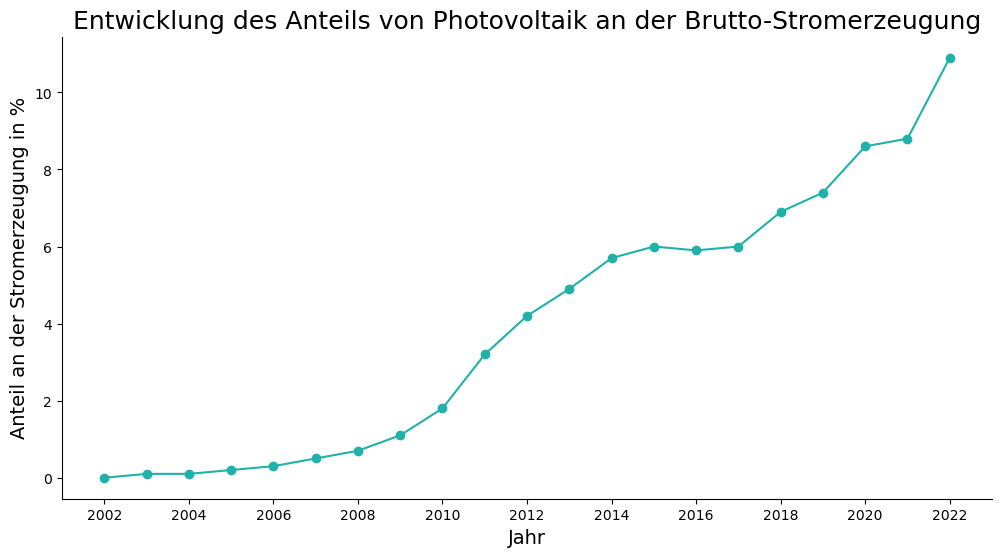

In [10]:
# Plot erstellen
plt.figure(figsize=(12, 6)) 
plt.plot(pv_ausbau['Jahr'], pv_ausbau['% Anteil'], marker='o', linestyle='-', color='lightseagreen')
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anteil an der Stromerzeugung in %', fontsize=14)
plt.title('Entwicklung des Anteils von Photovoltaik an der Brutto-Stromerzeugung', fontsize=18)
plt.xticks(pv_ausbau['Jahr'][::2])
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

- starker Anstieg des Anteils an PV an der Stromerzeugung zwischen 2009 und 2014    
- stagnierender Ausbau zwischen 2014 und 2017     
- seit 2018 erneut stetiger Anstieg bis auf 10,9% in 2022    

## Saisonale Muster beim PV-Ausbau

In [11]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

### Installierte Gesamtleistung aller PV-Anlagen nach Monat der Inbetriebnahme

In [12]:
# Datenbankabfrage
query_01 = """
SELECT
    strftime('%m', Inbetriebnahmedatum) AS Monat,
    SUM(Bruttoleistung) AS Gesamtleistung
FROM marktstammdaten
GROUP BY Monat
ORDER BY Monat;
"""
abfrage_01 = pd.read_sql_query(query_01, con=con)
abfrage_01

Monat  Gesamtleistung
0     01    4.674479e+06
1     02    3.800420e+06
2     03    7.556582e+06
3     04    5.799594e+06
4     05    6.263914e+06
5     06    1.173577e+07
6     07    4.899034e+06
7     08    5.189209e+06
8     09    6.178340e+06
9     10    4.981185e+06
10    11    5.445660e+06
11    12    1.189833e+07

In [13]:
# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(abfrage_01['Monat'], abfrage_01['Gesamtleistung'], marker='o', linestyle='-')
plt.title('Installierte Gesamtleistung aller PV-Anlagen nach Monat der Inbetriebnahme', fontsize=18)
plt.xlabel('Monat', fontsize=14)
plt.ylabel('Gesamtleistung in kW', fontsize=14)
plt.xticks(abfrage_01['Monat'])
plt.ticklabel_format(axis='y', style='plain')
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);
plt.show()

### Installierte Gesamtleistung aller PV-Anlagen nach Monat der Registrierung

In [14]:
# Datenbankabfrage
query_02 = """
SELECT
    strftime('%m', Registrierungsdatum) AS Monat,
    SUM(Bruttoleistung) AS Gesamtleistung
FROM marktstammdaten
GROUP BY Monat
ORDER BY Monat;
"""
abfrage_02 = pd.read_sql_query(query_02, con=con)
abfrage_02

Monat  Gesamtleistung
0     01     9734926.688
1     02     7399465.233
2     03     7198511.690
3     04     5778567.899
4     05     6351567.269
5     06     7318364.962
6     07     4889378.503
7     08     4291269.078
8     09     4732412.111
9     10     5845660.653
10    11     6492102.105
11    12     8390297.475

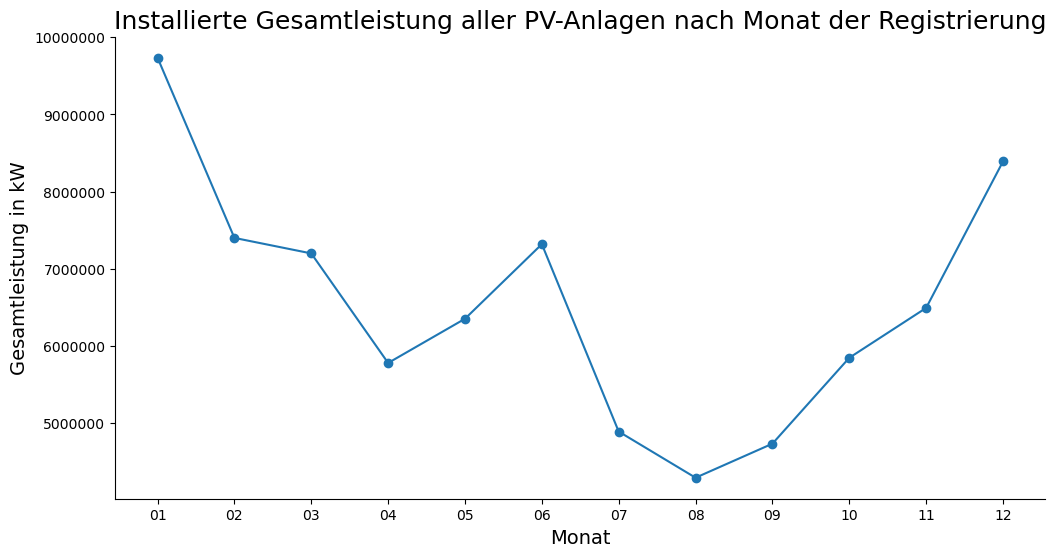

In [15]:
# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(abfrage_02['Monat'], abfrage_02['Gesamtleistung'], marker='o', linestyle='-')
plt.title('Installierte Gesamtleistung aller PV-Anlagen nach Monat der Registrierung', fontsize=18)
plt.xlabel('Monat', fontsize=14)
plt.ylabel('Gesamtleistung in kW', fontsize=14)
plt.xticks(abfrage_02['Monat'])
plt.ticklabel_format(axis='y', style='plain')
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);
plt.show()

## Regionale Unterschiede nach Bundesland

### Anzahl der in Betrieb genommenen PV-Anlagen pro Jahr nach Bundesland

In [16]:
# Datenbankabfrage
query_03 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    Bundesland,
    COUNT(*) AS Anzahl_PV_Anlagen
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) >= '2005'
GROUP BY Jahr, Bundesland
ORDER BY Jahr, Bundesland;
"""
abfrage_03 = pd.read_sql_query(query_03, con=con)
abfrage_03

Jahr          Bundesland  Anzahl_PV_Anlagen
0    2005   Baden-Württemberg              15462
1    2005              Bayern              25835
2    2005              Berlin                110
3    2005         Brandenburg                650
4    2005              Bremen                 55
..    ...                 ...                ...
299  2023            Saarland               4552
300  2023             Sachsen              18187
301  2023      Sachsen-Anhalt              12891
302  2023  Schleswig-Holstein              22077
303  2023           Thüringen              10321

[304 rows x 3 columns]

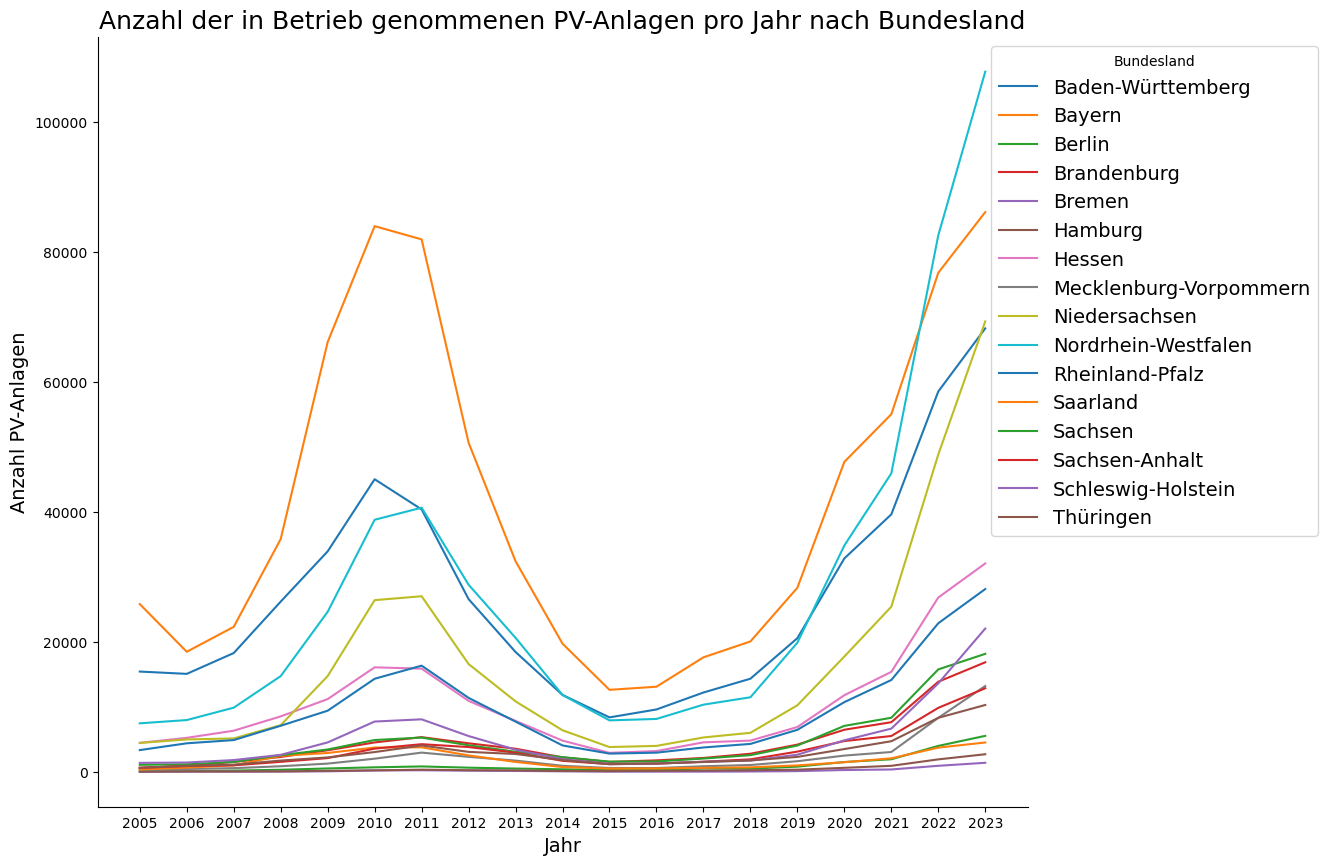

In [17]:
bundeslaender = abfrage_03['Bundesland'].unique()

# Plot erstellen
plt.figure(figsize=(12, 10))

for bundesland in bundeslaender:
    subset = abfrage_03[abfrage_03['Bundesland'] == bundesland]
    plt.plot(subset['Jahr'], subset['Anzahl_PV_Anlagen'], label=bundesland)

plt.title('Anzahl der in Betrieb genommenen PV-Anlagen pro Jahr nach Bundesland', fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
plt.legend(title='Bundesland', bbox_to_anchor=(0.95, 1), loc='upper left', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);
plt.show()

### Unterschiede bezüglich der installierten Brutto-Leistung nach Bundesland
zwischen 2005 und 2023

In [18]:
# Datenbank-Abfrage
query_05 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    Bundesland,
    AVG(Bruttoleistung) AS Durchschnitt_Bruttoleistung
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) >= '2005'
GROUP BY Jahr, Bundesland
ORDER BY Bundesland, Jahr;
"""
abfrage_05 = pd.read_sql_query(query_05, con=con)
abfrage_05

Jahr         Bundesland  Durchschnitt_Bruttoleistung
0    2005  Baden-Württemberg                    12.590840
1    2006  Baden-Württemberg                    12.782029
2    2007  Baden-Württemberg                    14.238445
3    2008  Baden-Württemberg                    15.041157
4    2009  Baden-Württemberg                    18.534570
..    ...                ...                          ...
299  2019          Thüringen                    81.962113
300  2020          Thüringen                    62.285181
301  2021          Thüringen                    50.001064
302  2022          Thüringen                    23.549278
303  2023          Thüringen                    13.477685

[304 rows x 3 columns]

In [19]:
# Plot erstellen
plt.figure(figsize=(12, 6))

bundeslaender = abfrage_05['Bundesland'].unique()

for bundesland in bundeslaender:
    subset = abfrage_05[abfrage_05['Bundesland'] == bundesland]
    plt.plot(subset['Jahr'], subset['Durchschnitt_Bruttoleistung'], label=bundesland)

plt.title('Durchschnittliche installierte Bruttoleistung pro Jahr und Bundesland', fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Durchschnittliche Bruttoleistung (kWh)', fontsize=14)
plt.legend(title='Bundesland', bbox_to_anchor=(0.95, 1), loc='upper left')
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [20]:
# Durchschnitt der Bruttoleistung pro Bundesland berechnen
leistung = abfrage_05.groupby('Bundesland')['Durchschnitt_Bruttoleistung'].mean().reset_index()
leistung['Durchschnitt_Bruttoleistung'] = leistung['Durchschnitt_Bruttoleistung'].round().astype(int)
rang_leistung = leistung.sort_values(by='Durchschnitt_Bruttoleistung', ascending=False)
rang_leistung['Rang'] = range(1, len(rang_leistung) + 1)
rang_leistung

Bundesland  Durchschnitt_Bruttoleistung  Rang
7   Mecklenburg-Vorpommern                          105     1
3              Brandenburg                           75     2
13          Sachsen-Anhalt                           72     3
15               Thüringen                           46     4
12                 Sachsen                           40     5
14      Schleswig-Holstein                           30     6
1                   Bayern                           25     7
11                Saarland                           23     8
8            Niedersachsen                           22     9
10         Rheinland-Pfalz                           21    10
4                   Bremen                           20    11
0        Baden-Württemberg                           18    12
6                   Hessen                           18    13
9      Nordrhein-Westfalen                           18    14
2                   Berlin                           14    15
5                  Hamburg                           12    16

Die weitaus größten PV-Anlagen werden in Mecklenburg-Vorpommern installiert.    
Aber auch in Brandenburg und Sachsen-Anhalt ist die durchschnittliche Brutto-Leistung hoch.    
Die im Durchschnitt kleinsten Anlagen werden in Hamburg und Berlin installiert.   

## Regionale Unterschiede anhand der Postleitzahl

### Prozentualer Zuwachs an PV-Anlagen pro Postleitzahl von 2018 bis 2023

In [21]:
# Datenbank-Abfrage
query_06 = """
SELECT
    msd.[Postleitzahl],
    msd.Ort,
    msd.Bundesland,
    SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) < '2018' THEN 1 ELSE 0 END) AS Anzahl_Vor_2018,
    SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) >= '2018' THEN 1 ELSE 0 END) AS Anzahl_Ab_2018,
    (SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) >= '2018' THEN 1 ELSE 0 END) * 100.0) /
    NULLIF(SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) < '2018' THEN 1 ELSE 0 END), 0) AS Prozentualer_Zuwachs
FROM marktstammdaten AS msd
GROUP BY msd.[Postleitzahl]
ORDER BY msd.[Postleitzahl];
"""
abfrage_06 = pd.read_sql_query(query_06, con=con)
abfrage_06

Postleitzahl            Ort Bundesland  Anzahl_Vor_2018  Anzahl_Ab_2018  \
0           01067        Dresden    Sachsen               16              25   
1           01069        Dresden    Sachsen               29              35   
2           01097        Dresden    Sachsen               19              41   
3           01099        Dresden    Sachsen               34             108   
4           01108        Dresden    Sachsen               93             193   
...           ...            ...        ...              ...             ...   
8155        99988        Diedorf  Thüringen               67              83   
8156        99991  Großengottern  Thüringen               70              87   
8157        99994    Marolterode  Thüringen               77              78   
8158        99996         Urbach  Thüringen               46              47   
8159        99998     Weinbergen  Thüringen              106             112   

      Prozentualer_Zuwachs  
0               156.250000  
1               120.689655  
2               215.789474  
3               317.647059  
4               207.526882  
...                    ...  
8155            123.880597  
8156            124.285714  
8157            101.298701  
8158            102.173913  
8159            105.660377  

[8160 rows x 6 columns]

In [22]:
# Top 15 Gemeinden mit aggregiertem prozentualen Zuwachs zwischen 2018 und 2023
agg_df = abfrage_06.groupby(['Postleitzahl', 'Ort', 'Bundesland']).agg({'Prozentualer_Zuwachs': 'sum'}).reset_index()
top_15_agg = agg_df.sort_values(by='Prozentualer_Zuwachs', ascending=False).head(15)
top_15_agg

Postleitzahl         Ort           Bundesland  Prozentualer_Zuwachs
743         12687      Berlin               Berlin           1250.000000
3491        50677        Köln  Nordrhein-Westfalen           1100.000000
4829        69117  Heidelberg    Baden-Württemberg            900.000000
669         10825      Berlin               Berlin            900.000000
687         12059      Berlin               Berlin            900.000000
1161        20255     Hamburg              Hamburg            800.000000
648         10585      Berlin               Berlin            800.000000
771         13409      Berlin               Berlin            800.000000
647         10559      Berlin               Berlin            766.666667
695         12159      Berlin               Berlin            750.000000
770         13407      Berlin               Berlin            733.333333
763         13351      Berlin               Berlin            700.000000
697         12163      Berlin               Berlin            700.000000
8098        99331     Geratal            Thüringen            655.555556
3489        50674        Köln  Nordrhein-Westfalen            650.000000

In [23]:
# Bottom 15 Gemeinden mit aggregiertem prozentualen Zuwachs zwischen 2018 und 2023
agg_df = abfrage_06.groupby(['Postleitzahl', 'Ort', 'Bundesland']).agg({'Prozentualer_Zuwachs': 'sum'}).reset_index()
bottom_15_agg = agg_df.sort_values(by='Prozentualer_Zuwachs', ascending=False).tail(15)
bottom_15_agg

Postleitzahl               Ort           Bundesland  Prozentualer_Zuwachs
3017        42103         Wuppertal  Nordrhein-Westfalen             11.111111
6012        82447     Spatzenhausen               Bayern              6.060606
2924        40213        Düsseldorf  Nordrhein-Westfalen              0.000000
2344        33333         Gütersloh  Nordrhein-Westfalen              0.000000
2923        40212        Düsseldorf  Nordrhein-Westfalen              0.000000
6015        82475  Schneefernerhaus               Bayern              0.000000
6074        83256    Frauenchiemsee               Bayern              0.000000
663         10779            Berlin               Berlin              0.000000
1785        25867             Oland   Schleswig-Holstein              0.000000
5891        81248           München               Bayern              0.000000
6623        86941      St. Ottilien               Bayern              0.000000
1158        20249           Hamburg              Hamburg              0.000000
1164        20354           Hamburg              Hamburg              0.000000
5638        78266          Büsingen    Baden-Württemberg              0.000000
1332        22301           Hamburg              Hamburg              0.000000

In [24]:
# Besonders hohe Zuwachsraten für Berlin > in welcher Lage?
query_30 = """
SELECT
    msd.Ort,
    msd.Lage,
    SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) < '2018' THEN 1 ELSE 0 END) AS Anzahl_Vor_2018,
    SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) >= '2018' THEN 1 ELSE 0 END) AS Anzahl_Ab_2018,
    (SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) >= '2018' THEN 1 ELSE 0 END) * 100.0) /
    NULLIF(SUM(CASE WHEN strftime('%Y', msd.Inbetriebnahmedatum) < '2018' THEN 1 ELSE 0 END), 0) AS Prozentualer_Zuwachs
FROM marktstammdaten AS msd
WHERE msd.Ort = 'Berlin'
GROUP BY msd.[Lage]
ORDER BY msd.[Lage];
"""
abfrage_30 = pd.read_sql_query(query_30, con=con)
abfrage_30

Ort                                               Lage  Anzahl_Vor_2018  \
0  Berlin   Bauliche Anlagen (Hausdach, Gebäude und Fassade)             6475   
1  Berlin                        Bauliche Anlagen (Sonstige)              106   
2  Berlin                                         Freifläche                8   
3  Berlin  Steckerfertige Erzeugungsanlage (sog. Plug-In-...               11   

   Anzahl_Ab_2018  Prozentualer_Zuwachs  
0           10642            164.355212  
1             185            174.528302  
2              29            362.500000  
3            3599          32718.181818

## Regionale Unterschiede anhand der AGS-5

### Top 20 Gemeinden Anzahl PV-Installationen pro 10.000 Einwohner
bezogen auf Inbetriebnahmen zwischen 2005 und 2023

In [25]:
# Datenbank-Abfrage
query_12 = """
SELECT
    msd.[Ort],
    msd.[Bundesland],
    msd.[AGS-5],
    COUNT(*) * 10000.0 / bd.Bevölkerung AS PV_Anlagen_pro_10k_Einwohner
FROM marktstammdaten AS msd
JOIN bevoelkerungsdichte AS bd ON msd.[AGS-5] = bd.[AGS-5]
WHERE strftime('%Y', msd.Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY msd.[AGS-5]
"""
abfrage_12 = pd.read_sql_query(query_12, con=con)
abfrage_12

Ort          Bundesland  AGS-5  PV_Anlagen_pro_10k_Einwohner
0          Flensburg  Schleswig-Holstein  01001                    135.875232
1               Kiel  Schleswig-Holstein  01002                     76.997113
2             Lübeck  Schleswig-Holstein  01003                    115.130134
3         Neumünster  Schleswig-Holstein  01004                    189.695079
4       Hemmingstedt  Schleswig-Holstein  01051                    660.302010
..               ...                 ...    ...                           ...
395  Bad Blankenburg           Thüringen  16073                    275.034912
396        Hermsdorf           Thüringen  16074                    348.429944
397           Krölpa           Thüringen  16075                    322.662280
398    Auma-Weidatal           Thüringen  16076                    327.568625
399      Kriebitzsch           Thüringen  16077                    294.623435

[400 rows x 4 columns]

In [26]:
# TOP-20 Gemeinden
abfrage_12['PV_Anlagen_pro_10k_Einwohner'] = abfrage_12['PV_Anlagen_pro_10k_Einwohner'].round().astype(int)
abfrage_12 = abfrage_12.sort_values(by='PV_Anlagen_pro_10k_Einwohner', ascending=False)
abfrage_12.head(20)

Ort Bundesland  AGS-5  PV_Anlagen_pro_10k_Einwohner
254                 Arnstorf     Bayern  09277                          1501
256             Moosthenning     Bayern  09279                          1443
255  Mallersdorf-Pfaffenberg     Bayern  09278                          1407
252              Fürstenzell     Bayern  09275                          1229
251             Geisenhausen     Bayern  09274                          1193
316                 Kaisheim     Bayern  09779                          1184
248               Deggendorf     Bayern  09271                          1163
315                 Kronburg     Bayern  09778                          1148
249                Röhrnbach     Bayern  09272                          1144
261                     Rötz     Bayern  09372                          1140
285             Feuchtwangen     Bayern  09571                          1118
250                 Mainburg     Bayern  09273                          1102
225                   Perach     Bayern  09171                          1091
314               Roßhaupten     Bayern  09777                          1075
310                    Glött     Bayern  09773                          1058
289            Bad Windsheim     Bayern  09575                          1032
253                 Frauenau     Bayern  09276                          1025
291               Pappenheim     Bayern  09577                          1007
260                 Auerbach     Bayern  09371                           989
263                 Neustadt     Bayern  09374                           985

### Bottom 20 Gemeinden Anzahl PV-Installationen pro 10.000 Einwohner
bezogen auf Inbetriebnahmen zwischen 2005 und 2023

In [27]:
# Bottom-20 Gemeinden
abfrage_12['PV_Anlagen_pro_10k_Einwohner'] = abfrage_12['PV_Anlagen_pro_10k_Einwohner'].round().astype(int)
abfrage_12 = abfrage_12.sort_values(by='PV_Anlagen_pro_10k_Einwohner', ascending=False)
abfrage_12.tail(20)

Ort              Bundesland  AGS-5  \
343        Rostock  Mecklenburg-Vorpommern  13003   
119      Wiesbaden                  Hessen  06414   
65           Essen     Nordrhein-Westfalen  05113   
361        Leipzig                 Sachsen  14713   
178      Stuttgart       Baden-Württemberg  08111   
62     Bremerhaven                  Bremen  04012   
64        Duisburg     Nordrhein-Westfalen  05112   
328        Potsdam             Brandenburg  12054   
356        Dresden                 Sachsen  14612   
108          Herne     Nordrhein-Westfalen  05916   
90   Gelsenkirchen     Nordrhein-Westfalen  05513   
1             Kiel      Schleswig-Holstein  01002   
79            Köln     Nordrhein-Westfalen  05315   
61          Bremen                  Bremen  04011   
223        München                  Bayern  09162   
63      Düsseldorf     Nordrhein-Westfalen  05111   
324         Berlin                  Berlin  11000   
118      Offenbach                  Hessen  06413   
15         Hamburg                 Hamburg  02000   
117      Frankfurt                  Hessen  06412   

     PV_Anlagen_pro_10k_Einwohner  
343                            97  
119                            93  
65                             93  
361                            93  
178                            93  
62                             92  
64                             91  
328                            88  
356                            88  
108                            86  
90                             82  
1                              77  
79                             77  
61                             70  
223                            67  
63                             62  
324                            55  
118                            53  
15                             51  
117                            51

ALLE top-20 Gemeinden bei der Neuinstallation von PV-Anlagen liegen in Bayern.   
Pro 10.000 Einwohner wurden zwischen 985 und 1501 PV-Anlagen installiert.   
Die wenigsten PV-Anlagen wurden in Großstädten, Wie Frankfurt, Hamburg, Offenbach und Berlin installiert.

### Top 20 Gemeinden nach  intallierter Bruttoleistung pro 10.000 Einwohner
bezogen auf Inbetriebnahmen zwischen 2005 und 2023

In [28]:
# Datenbank-Abfrage
query_13 = """
SELECT
    msd.[Ort],
    msd.[Bundesland],
    msd.[AGS-5],
    SUM(msd.Bruttoleistung) / (bd.Bevölkerung / 10000) AS Bruttoleistung_pro_10k_Einwohner
FROM marktstammdaten AS msd
JOIN bevoelkerungsdichte AS bd ON msd.[AGS-5] = bd.[AGS-5]
WHERE strftime('%Y', msd.Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY msd.[AGS-5]
"""
abfrage_13 = pd.read_sql_query(query_13, con=con)
abfrage_13

Ort          Bundesland  AGS-5  \
0          Flensburg  Schleswig-Holstein  01001   
1               Kiel  Schleswig-Holstein  01002   
2             Lübeck  Schleswig-Holstein  01003   
3         Neumünster  Schleswig-Holstein  01004   
4       Hemmingstedt  Schleswig-Holstein  01051   
..               ...                 ...    ...   
395  Bad Blankenburg           Thüringen  16073   
396        Hermsdorf           Thüringen  16074   
397           Krölpa           Thüringen  16075   
398    Auma-Weidatal           Thüringen  16076   
399      Kriebitzsch           Thüringen  16077   

     Bruttoleistung_pro_10k_Einwohner  
0                         2558.721368  
1                         1074.703606  
2                         1958.363025  
3                         3349.956476  
4                        27647.260486  
..                                ...  
395                       7809.443691  
396                      22323.074303  
397                      15993.572820  
398                      16348.127510  
399                      18233.655973  

[400 rows x 4 columns]

In [29]:
# TOP-20 Gemeinden
abfrage_13['Bruttoleistung_pro_10k_Einwohner'] = abfrage_13['Bruttoleistung_pro_10k_Einwohner'].round().astype(int)
abfrage_13 = abfrage_13.sort_values(by='Bruttoleistung_pro_10k_Einwohner', ascending=False)
abfrage_13.head(20)

Ort              Bundesland  AGS-5  \
339                Pritzwalk             Brandenburg  12070   
335              Luckaitztal             Brandenburg  12066   
333   Fredersdorf-Vogelsdorf             Brandenburg  12064   
255  Mallersdorf-Pfaffenberg                  Bayern  09278   
155                 Holsthum         Rheinland-Pfalz  07232   
331                 Herzberg             Brandenburg  12062   
256             Moosthenning                  Bayern  09279   
298           Maroldsweisach                  Bayern  09674   
350                   Malliß  Mecklenburg-Vorpommern  13076   
340                Spremberg             Brandenburg  12071   
250                 Mainburg                  Bayern  09273   
254                 Arnstorf                  Bayern  09277   
367                 Kuhfelde          Sachsen-Anhalt  15081   
291               Pappenheim                  Bayern  09577   
239               Gachenbach                  Bayern  09185   
289            Bad Windsheim                  Bayern  09575   
285             Feuchtwangen                  Bayern  09571   
373                 Allstedt          Sachsen-Anhalt  15087   
342                 Prenzlau             Brandenburg  12073   
248               Deggendorf                  Bayern  09271   

     Bruttoleistung_pro_10k_Einwohner  
339                             63863  
335                             63269  
333                             57208  
255                             50884  
155                             49046  
331                             46643  
256                             46266  
298                             45492  
350                             42998  
340                             42744  
250                             40683  
254                             39922  
367                             39849  
291                             39625  
239                             39048  
289                             38276  
285                             38235  
373                             38106  
342                             37648  
248                             36755

### Bottom 20 Gemeinden nach  intallierter Bruttoleistung pro 10.000 Einwohner
bezogen auf Inbetriebnahmen zwischen 2005 und 2023

In [30]:
# BOTTOM-20 Gemeinden
abfrage_13['Bruttoleistung_pro_10k_Einwohner'] = abfrage_13['Bruttoleistung_pro_10k_Einwohner'].round().astype(int)
abfrage_13 = abfrage_13.sort_values(by='Bruttoleistung_pro_10k_Einwohner', ascending=False)
abfrage_13.tail(20)

Ort           Bundesland  AGS-5  \
380           Jena            Thüringen  16053   
90   Gelsenkirchen  Nordrhein-Westfalen  05513   
62     Bremerhaven               Bremen  04012   
78            Bonn  Nordrhein-Westfalen  05314   
356        Dresden              Sachsen  14612   
72       Wuppertal  Nordrhein-Westfalen  05124   
61          Bremen               Bremen  04011   
119      Wiesbaden               Hessen  06414   
64        Duisburg  Nordrhein-Westfalen  05112   
178      Stuttgart    Baden-Württemberg  08111   
79            Köln  Nordrhein-Westfalen  05315   
118      Offenbach               Hessen  06413   
1             Kiel   Schleswig-Holstein  01002   
65           Essen  Nordrhein-Westfalen  05113   
108          Herne  Nordrhein-Westfalen  05916   
63      Düsseldorf  Nordrhein-Westfalen  05111   
223        München               Bayern  09162   
117      Frankfurt               Hessen  06412   
324         Berlin               Berlin  11000   
15         Hamburg              Hamburg  02000   

     Bruttoleistung_pro_10k_Einwohner  
380                              1477  
90                               1450  
62                               1387  
78                               1369  
356                              1357  
72                               1348  
61                               1313  
119                              1286  
64                               1225  
178                              1183  
79                               1181  
118                              1109  
1                                1075  
65                               1074  
108                              1030  
63                                886  
223                               822  
117                               794  
324                               655  
15                                558

## Effizienzsteigerung von PV-Modulen
zwischen 2005 und 2023    
Durchschnittliche Leistung der installierten Module in KW nach Jahr

In [31]:
# Datenbank-Abfrage
query_08 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    AVG(Bruttoleistung / AnzahlModule) AS Durchschnittliche_Leistung
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY Jahr
ORDER BY Jahr;
"""
abfrage_08 = pd.read_sql_query(query_08, con=con)
abfrage_08

Jahr  Durchschnittliche_Leistung
0   2005                    0.138898
1   2006                    0.145222
2   2007                    0.125506
3   2008                    0.113723
4   2009                    0.134756
5   2010                    0.164694
6   2011                    0.171408
7   2012                    0.202208
8   2013                    0.175273
9   2014                    0.225447
10  2015                    0.223303
11  2016                    0.231938
12  2017                    0.271809
13  2018                    0.269245
14  2019                    0.301512
15  2020                    0.331518
16  2021                    0.372748
17  2022                    0.448622
18  2023                    0.468371

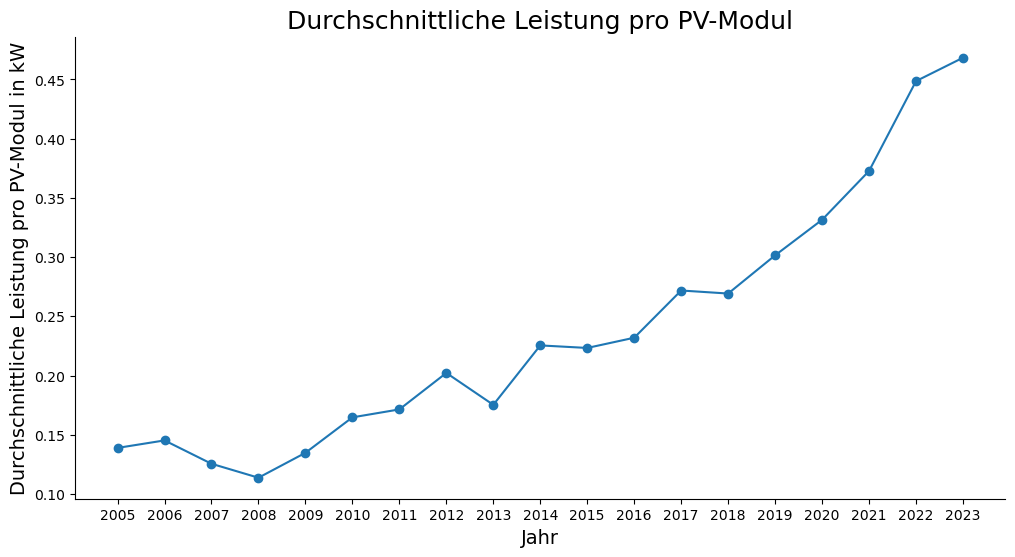

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(abfrage_08['Jahr'], abfrage_08['Durchschnittliche_Leistung'], marker='o', linestyle='-')
plt.title('Durchschnittliche Leistung pro PV-Modul', fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Durchschnittliche Leistung pro PV-Modul in kW', fontsize=14)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Entwicklung der Nutzungsbereiche
zwischen 2005 und 2023

In [33]:
# Datenbank-Abfrage
query_08 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    Nutzungsbereich,
    COUNT(*) AS Anzahl
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY Jahr, Nutzungsbereich
ORDER BY Jahr;
"""
abfrage_08 = pd.read_sql_query(query_08, con=con)
abfrage_08.tail(10)

Jahr                       Nutzungsbereich  Anzahl
104  2022                             Industrie    2137
105  2022                        Landwirtschaft   11950
106  2022                              Sonstige    9853
107  2022                  Öffentliches Gebäude    2156
108  2023  Gewerbe, Handel und Dienstleistungen   23840
109  2023                              Haushalt  436009
110  2023                             Industrie    2807
111  2023                        Landwirtschaft   20933
112  2023                              Sonstige   13322
113  2023                  Öffentliches Gebäude    2648

In [34]:
# DataFrame pivotieren
pivot_df = abfrage_08.pivot(index='Jahr', columns='Nutzungsbereich', values='Anzahl')
pivot_df.fillna(0, inplace=True)

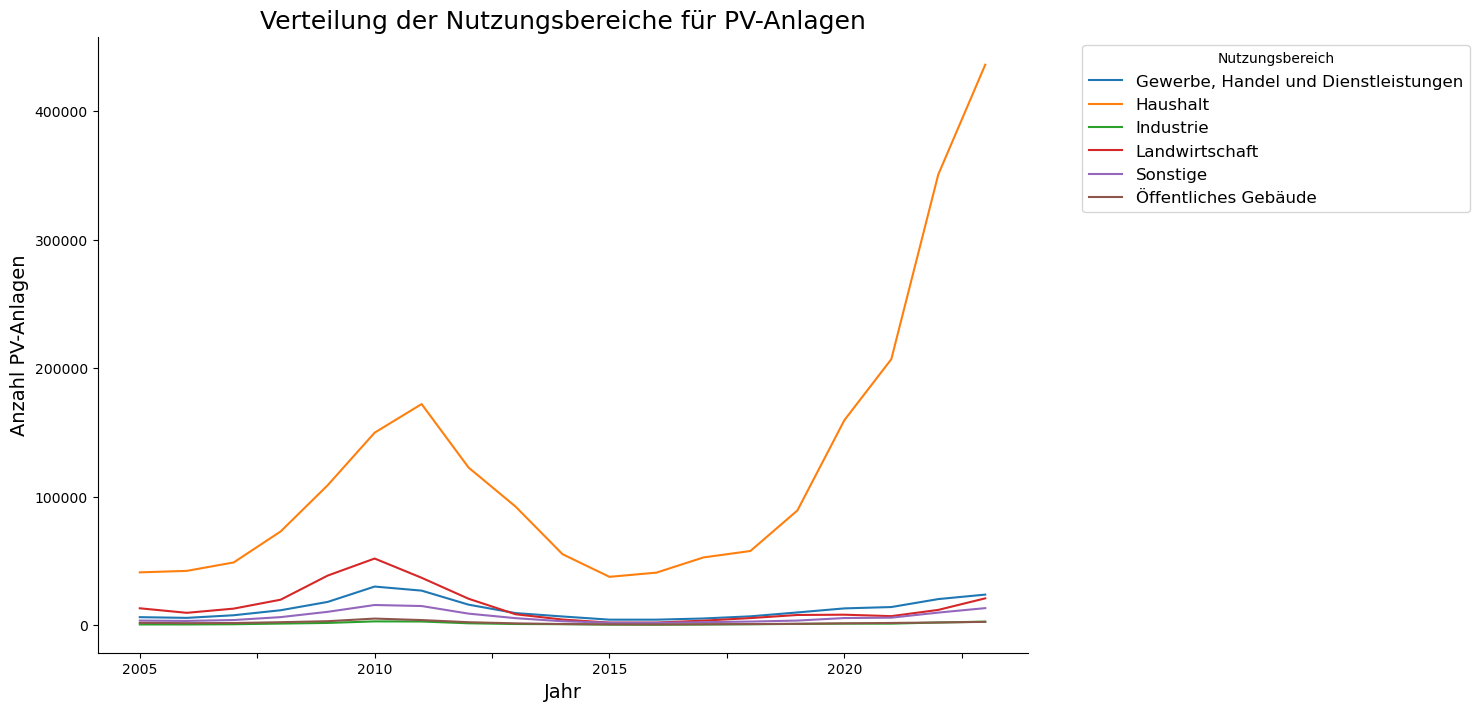

In [35]:
# Gestapeltes Flächendiagramm erstellen
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='line', stacked=False, ax=ax)
plt.title('Verteilung der Nutzungsbereiche für PV-Anlagen', fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
plt.legend(title='Nutzungsbereich', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Bis 2011 haben PV-Anlagen in der Landwirtschaft noch einen wesentlichen Anteil am gesamten PV-Ausbau ausgemacht.    
Nach dem Einbruch des Ausbaus zwischen 2012 und 2018 wurde dieses Niveau nicht wieder erreicht.   
Maßgeblicher Treiber beim PV-Ausbau sind private Haushalte.    

## Entwicklung der Lage

In [36]:
# Datenbank-Abfrage
query_10 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    Lage,
    COUNT(*) AS Anzahl
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY Jahr, Lage
ORDER BY Jahr;
"""
abfrage_10 = pd.read_sql_query(query_10, con=con)
abfrage_10.tail(20)

Jahr                                               Lage  Anzahl
60  2019  Steckerfertige Erzeugungsanlage (sog. Plug-In-...     233
61  2020   Bauliche Anlagen (Hausdach, Gebäude und Fassade)  183886
62  2020                        Bauliche Anlagen (Sonstige)    2608
63  2020                                         Freifläche     997
64  2020  Steckerfertige Erzeugungsanlage (sog. Plug-In-...    1669
65  2021   Bauliche Anlagen (Hausdach, Gebäude und Fassade)  223920
66  2021                        Bauliche Anlagen (Sonstige)    2272
67  2021                                         Freifläche    1073
68  2021  Steckerfertige Erzeugungsanlage (sog. Plug-In-...    9913
69  2022   Bauliche Anlagen (Hausdach, Gebäude und Fassade)  325974
70  2022                        Bauliche Anlagen (Sonstige)    5109
71  2022                                         Freifläche    1840
72  2022                                           Gewässer       9
73  2022  Steckerfertige Erzeugungsanlage (sog. Plug-In-...   64155
74  2023   Bauliche Anlagen (Hausdach, Gebäude und Fassade)  343430
75  2023                        Bauliche Anlagen (Sonstige)    5892
76  2023                                         Freifläche    1659
77  2023                                           Gewässer      13
78  2023                                      Großparkplatz      11
79  2023  Steckerfertige Erzeugungsanlage (sog. Plug-In-...  148554

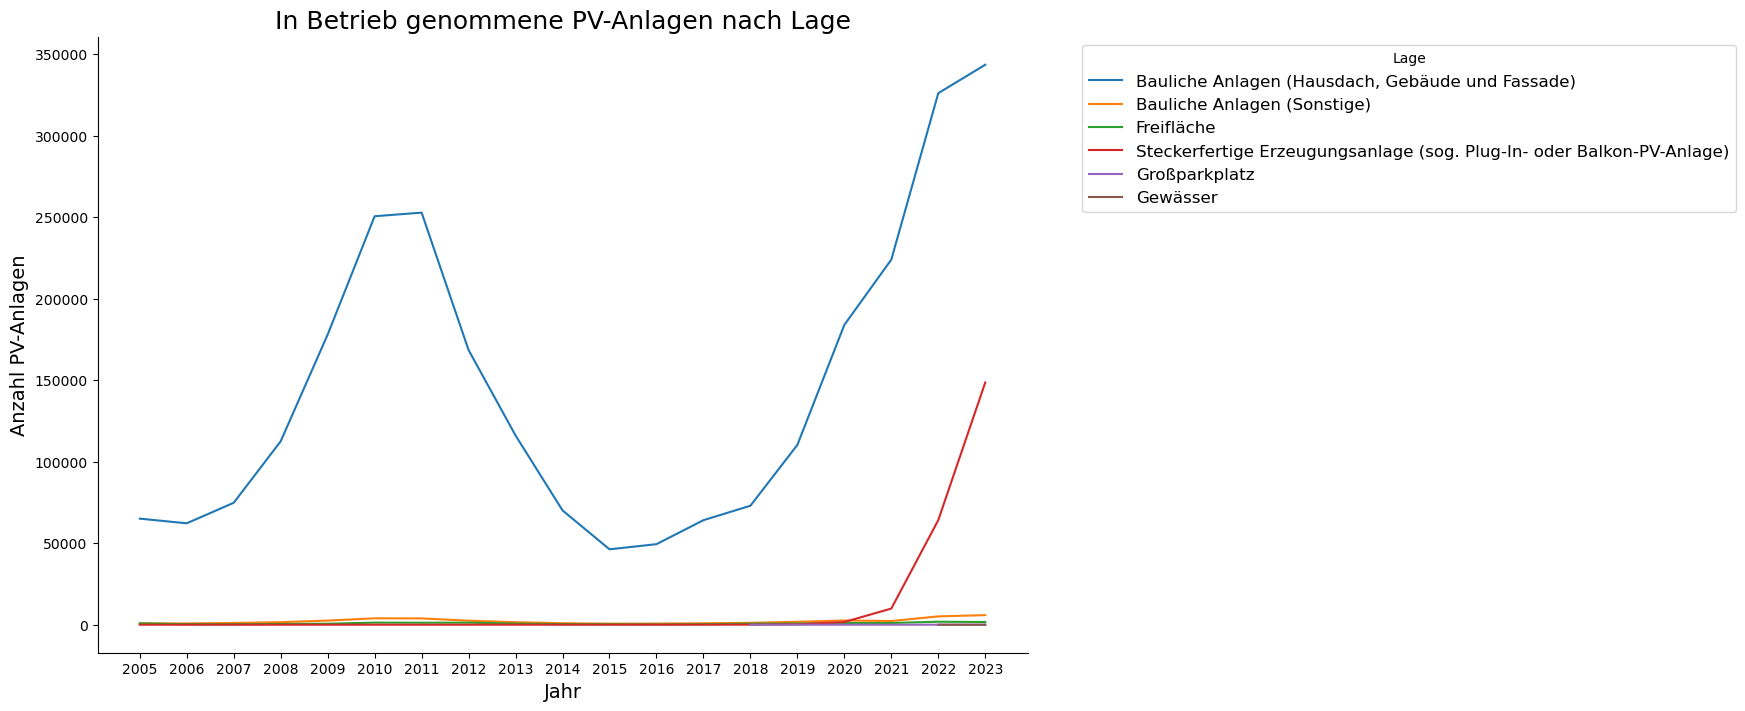

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
for lage in abfrage_10['Lage'].unique():
    subset = abfrage_10[abfrage_10['Lage'] == lage]
    plt.plot(subset['Jahr'], subset['Anzahl'], label=lage)

plt.title("In Betrieb genommene PV-Anlagen nach Lage", fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
plt.legend(title='Lage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Der weit größte Anteil von PV-Anlagen wird auf baulichen Anlagen, wie Hausdächern, Gebäuden oder Fassaden installiert.   
Seit 2021 gibt es einen sprunghaften Anstieg sogenannter Plug-In oder Balkon-Anlagen.

## Entwicklung bei der bevorzugten Hauptausrichtung

In [38]:
# Datenbank-Abfrage
query_11 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    Hauptausrichtung,
    COUNT(*) AS Anzahl
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY Jahr, Hauptausrichtung
ORDER BY Jahr;
"""
abfrage_11 = pd.read_sql_query(query_11, con=con)
#abfrage_11

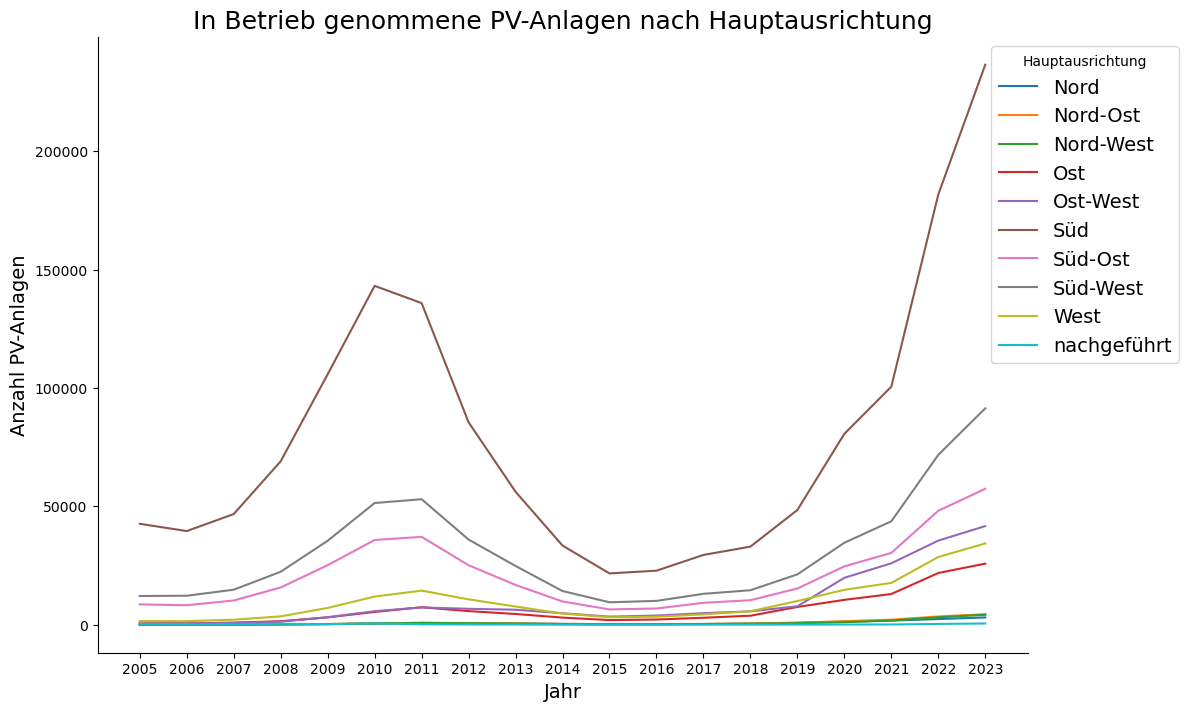

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
for lage in abfrage_11['Hauptausrichtung'].unique():
    subset = abfrage_11[abfrage_11['Hauptausrichtung'] == lage]
    plt.plot(subset['Jahr'], subset['Anzahl'], label=lage)

plt.title("In Betrieb genommene PV-Anlagen nach Hauptausrichtung", fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
plt.legend(title='Hauptausrichtung', bbox_to_anchor=(0.95, 1), loc='upper left', fontsize=14)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Entwicklung der Einspeisungsart

In [40]:
# Datenbank-Abfrage
query_14 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    Einspeisungsart,
    COUNT(*) AS Anzahl
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY Jahr, Einspeisungsart
ORDER BY Jahr;
"""
abfrage_14 = pd.read_sql_query(query_14, con=con)
#abfrage_14

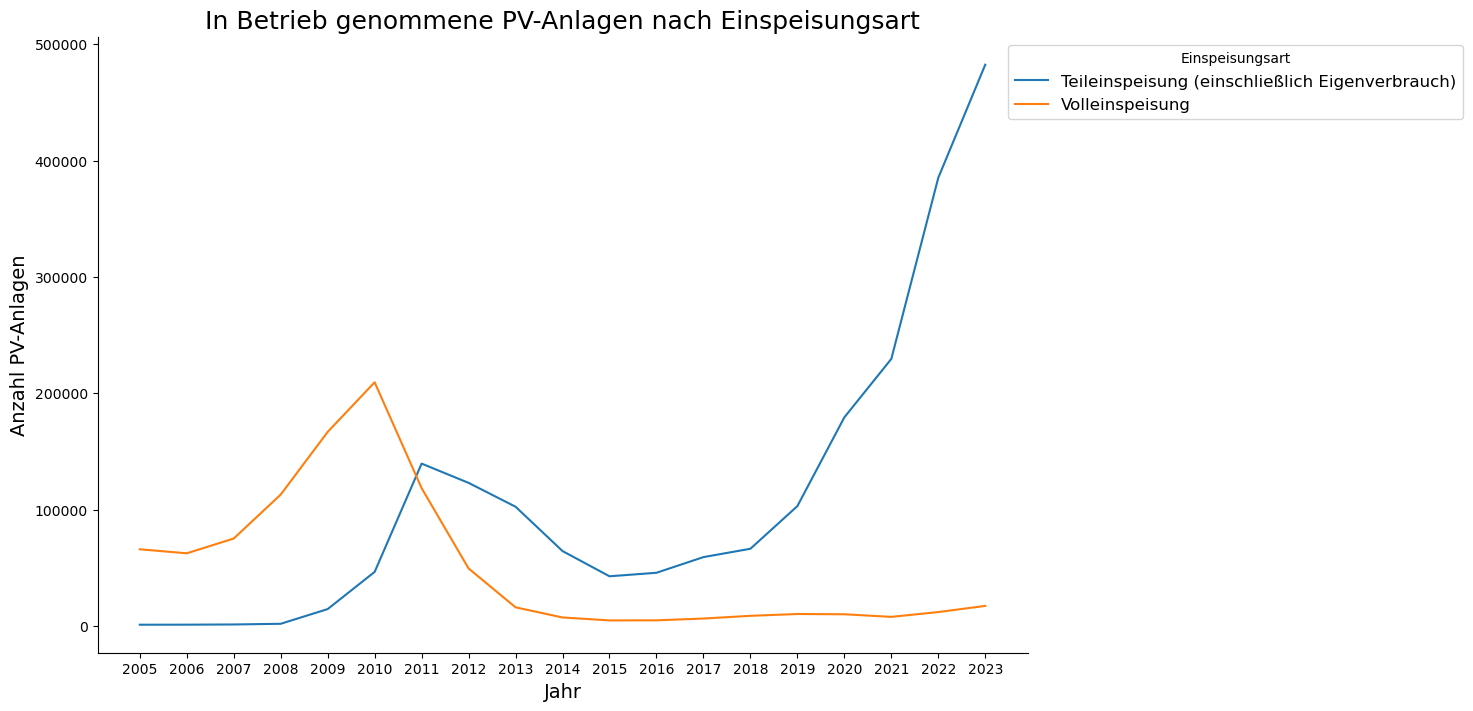

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
for lage in abfrage_14['Einspeisungsart'].unique():
    subset = abfrage_14[abfrage_14['Einspeisungsart'] == lage]
    plt.plot(subset['Jahr'], subset['Anzahl'], label=lage)

plt.title("In Betrieb genommene PV-Anlagen nach Einspeisungsart", fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
plt.legend(title='Einspeisungsart', bbox_to_anchor=(0.97, 1), loc='upper left', fontsize=12)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

## Entwicklung der Leistungsbegrenzung

In [42]:
# Datenbank-Abfrage
query_22 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    Leistungsbegrenzung,
    COUNT(*) AS Anzahl
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY Jahr, Leistungsbegrenzung
ORDER BY Jahr;
"""
abfrage_22 = pd.read_sql_query(query_22, con=con)
#abfrage_22

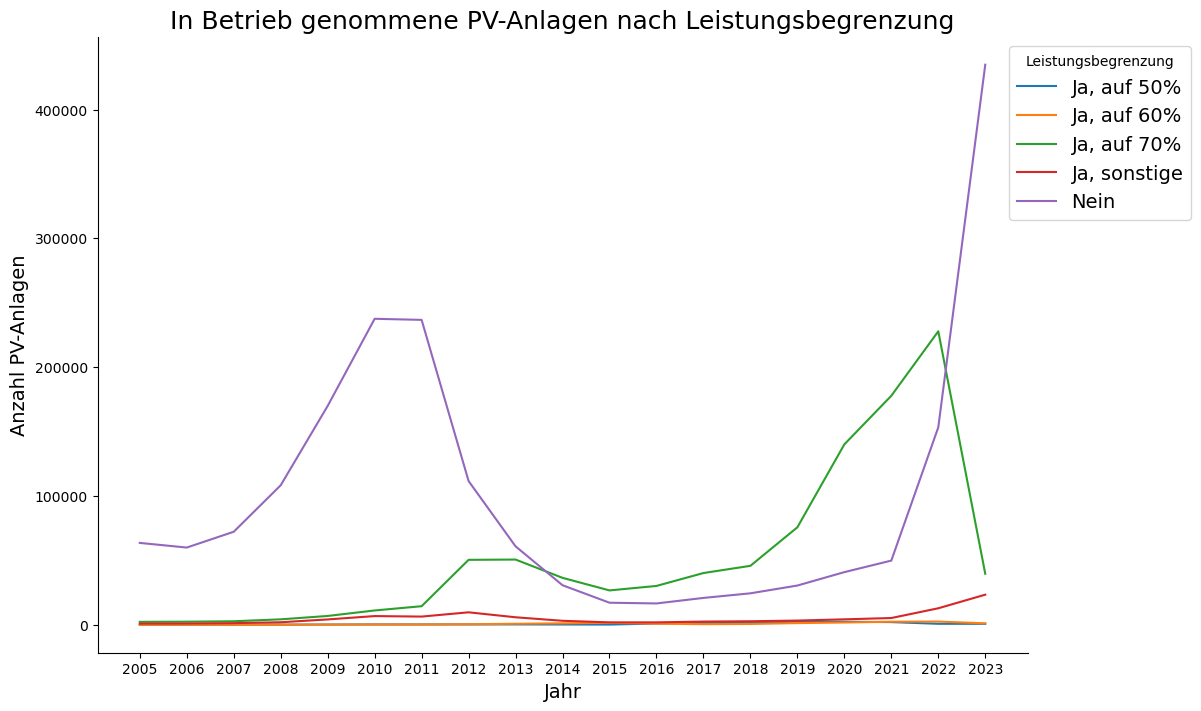

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
for lage in abfrage_22['Leistungsbegrenzung'].unique():
    subset = abfrage_22[abfrage_22['Leistungsbegrenzung'] == lage]
    plt.plot(subset['Jahr'], subset['Anzahl'], label=lage)

plt.title("In Betrieb genommene PV-Anlagen nach Leistungsbegrenzung", fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
plt.legend(title='Leistungsbegrenzung', bbox_to_anchor=(0.97, 1), loc='upper left', fontsize=14)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Entwicklung bezüglich GemeinsamerWechselrichterMitSpeicher

In [44]:
# Datenbank-Abfrage
query_23 = """
SELECT
    strftime('%Y', Inbetriebnahmedatum) AS Jahr,
    GemeinsamerWechselrichterMitSpeicher,
    COUNT(*) AS Anzahl
FROM marktstammdaten
WHERE strftime('%Y', Inbetriebnahmedatum) BETWEEN '2005' AND '2023'
GROUP BY Jahr, GemeinsamerWechselrichterMitSpeicher
ORDER BY Jahr;
"""
abfrage_23 = pd.read_sql_query(query_23, con=con)
#abfrage_23

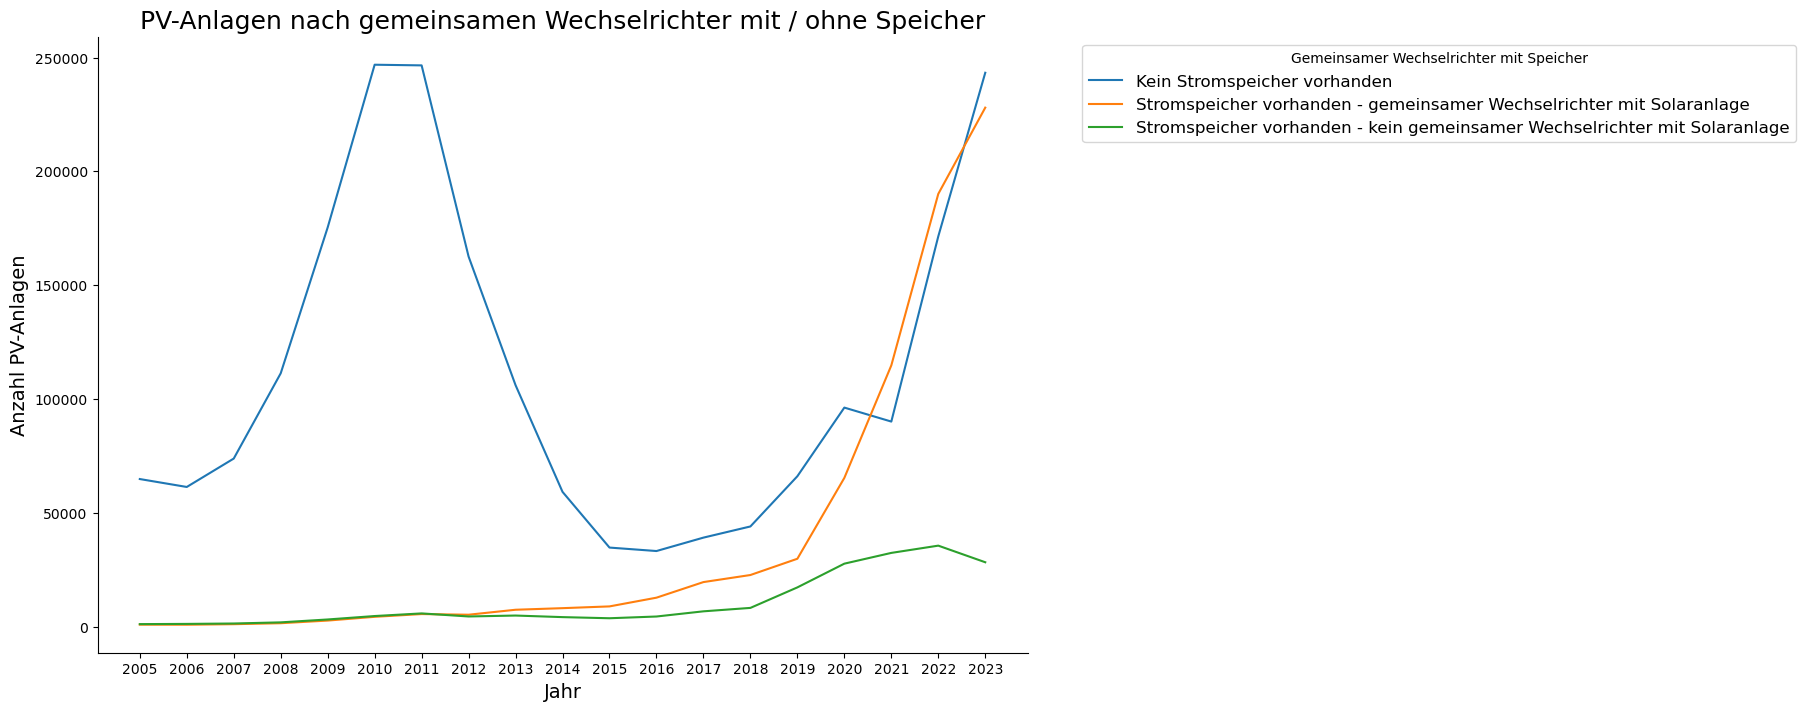

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
for lage in abfrage_23['GemeinsamerWechselrichterMitSpeicher'].unique():
    subset = abfrage_23[abfrage_23['GemeinsamerWechselrichterMitSpeicher'] == lage]
    plt.plot(subset['Jahr'], subset['Anzahl'], label=lage)

plt.title("PV-Anlagen nach gemeinsamen Wechselrichter mit / ohne Speicher", fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
plt.legend(title='Gemeinsamer Wechselrichter mit Speicher', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Betrachtung möglicher Abhängigkeiten

### Zusammenhang Strompreise, Einspeisevergütung und Einspeisungsart der installierten PV-Anlagen

In [46]:
# Datenbank-Abfrage
query_41 = """
SELECT
    strftime('%Y-%m', m.Inbetriebnahmedatum) AS Jahr_Monat,
    COUNT(CASE WHEN m.Einspeisungsart = 'Volleinspeisung' THEN 1 END) AS Anzahl_Volleinspeisung,
    COUNT(CASE WHEN m.Einspeisungsart = 'Teileinspeisung (einschließlich Eigenverbrauch)' THEN 1 END) AS Anzahl_Teileinspeisung,
    e.Einspeiseverguetung_kleine_PV_Anlagen AS Einspeiseverguetung,
    MAX(s.Strom_Verbraucherpreis) AS Strompreis
FROM marktstammdaten m
LEFT JOIN einspeiseverguetung e ON m.Inbetriebnahmedatum = e.Datum
LEFT JOIN strompreis s ON strftime('%Y', m.Inbetriebnahmedatum) = s.Jahr
WHERE m.Inbetriebnahmedatum BETWEEN '2005-01-01' AND '2023-06-30'
GROUP BY Jahr_Monat, Einspeiseverguetung_kleine_PV_Anlagen
ORDER BY Jahr_Monat;
"""
abfrage_41 = pd.read_sql_query(query_41, con=con)
abfrage_41

Jahr_Monat  Anzahl_Volleinspeisung  Anzahl_Teileinspeisung  \
0      2005-01                    1094                      15   
1      2005-01                    1064                      18   
2      2005-02                    1182                      16   
3      2005-02                      66                       0   
4      2005-03                    3312                      40   
..         ...                     ...                     ...   
439    2023-04                     286                    4900   
440    2023-05                    3434                   88302   
441    2023-05                     260                    4245   
442    2023-06                    3227                   73322   
443    2023-06                     397                    7936   

     Einspeiseverguetung  Strompreis  
0                    NaN       18.23  
1                  54.53       18.23  
2                    NaN       18.23  
3                  54.53       18.23  
4                    NaN       18.23  
..                   ...         ...  
439                 7.65       46.27  
440                  NaN       46.27  
441                 7.65       46.27  
442                  NaN       46.27  
443                 7.65       46.27  

[444 rows x 5 columns]

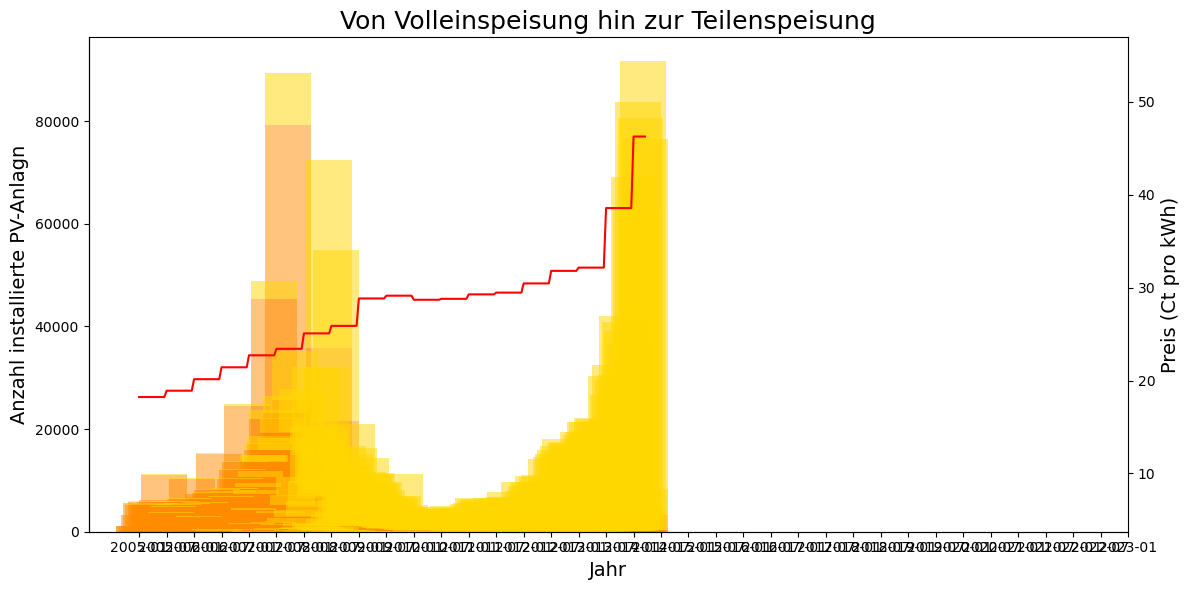

In [47]:
# Jahr_Monat in ein Datumsformat konvertieren
filtered_data = abfrage_41[abfrage_41['Jahr_Monat'] >= '2005-01']

fig, ax1 = plt.subplots(figsize=(12, 6))

# Säulen für Anzahl_Volleinspeisung und Anzahl_Teileinspeisung (als gestapeltes Säulendiagramm)
ax1.bar(filtered_data['Jahr_Monat'], filtered_data['Anzahl_Volleinspeisung'], 
        label='Anzahl_Volleinspeisung', width=20, color = 'darkorange', alpha=0.5)
ax1.bar(filtered_data['Jahr_Monat'], filtered_data['Anzahl_Teileinspeisung'], 
        label='Anzahl_Teileinspeisung', width=20, color = 'gold', alpha=0.5, bottom=filtered_data['Anzahl_Volleinspeisung'])

# Linien für Einspeisevergütung und Strompreis
ax2 = ax1.twinx()
ax2.plot(filtered_data['Jahr_Monat'], filtered_data['Einspeiseverguetung'], color='black', label='Einspeisevergütung')
ax2.plot(filtered_data['Jahr_Monat'], filtered_data['Strompreis'], color='red', label='Strompreis')

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Achsenbeschriftungen
ax1.set_xlabel('Jahr', fontsize=14)
ax1.set_ylabel('Anzahl installierte PV-Anlagn', fontsize=14)
ax2.set_ylabel('Preis (Ct pro kWh)', fontsize=14)

# Anpassung der x-Achsenbeschriftung für die Lesbarkeit
plt.xticks(range(0, len(filtered_data), 12), filtered_data['Jahr_Monat'][::12], rotation=45)

# Legenden anzeigen
#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

plt.title('Von Volleinspeisung hin zur Teilenspeisung', fontsize=18)
plt.tight_layout()

# Plot anzeigen
plt.show()

## Solar-Ausbau anhand der installierten Bruttoleistung

### Plot 1: installierten Bruttoleistung 2005-2008
Quellen: https://juanitorduz.github.io/germany_plots/   
         https://github.com/maxnoe/plz_plot/tree/master

In [48]:
# Datenbank-Abfrage
query_16 = """
SELECT msd.Inbetriebnahmedatum,  msd.Postleitzahl, msd.Bruttoleistung
FROM marktstammdaten AS msd
WHERE strftime('%Y', msd.Inbetriebnahmedatum) BETWEEN '2005' AND '2008';
"""
abfrage_16 = pd.read_sql_query(query_16, con=con)
#abfrage_16

In [49]:
leistung = abfrage_16.groupby(['Postleitzahl'])['Bruttoleistung'].sum().reset_index()
leistung

Postleitzahl  Bruttoleistung
0           01067         108.230
1           01069          29.965
2           01097          50.415
3           01099          98.570
4           01108         181.582
...           ...             ...
7956        99988         198.280
7957        99991         100.500
7958        99994         582.540
7959        99996          94.050
7960        99998         162.481

[7961 rows x 2 columns]

In [50]:
# Postleitzahlen Shapefile einlesen
# Quelle: https://ckan.open.nrw.de/dataset/deutschland-postleitzahlen-ne/resource/6b3c27ef-c17d-4969-b846-0da8c85256e9
gdf = gpd.read_file('../input/Shape/georef-germany-postleitzahl.shp', encoding='utf-8')
#gdf

In [51]:
# Shapefile Aussengrenzen Deutschland einlesen
# Quelle: https://hub.arcgis.com/datasets/ae25571c60d94ce5b7fcbf74e27c00e0/about
ger_borders = gpd.read_file('../input/Shape/vg2500_sta.shp')

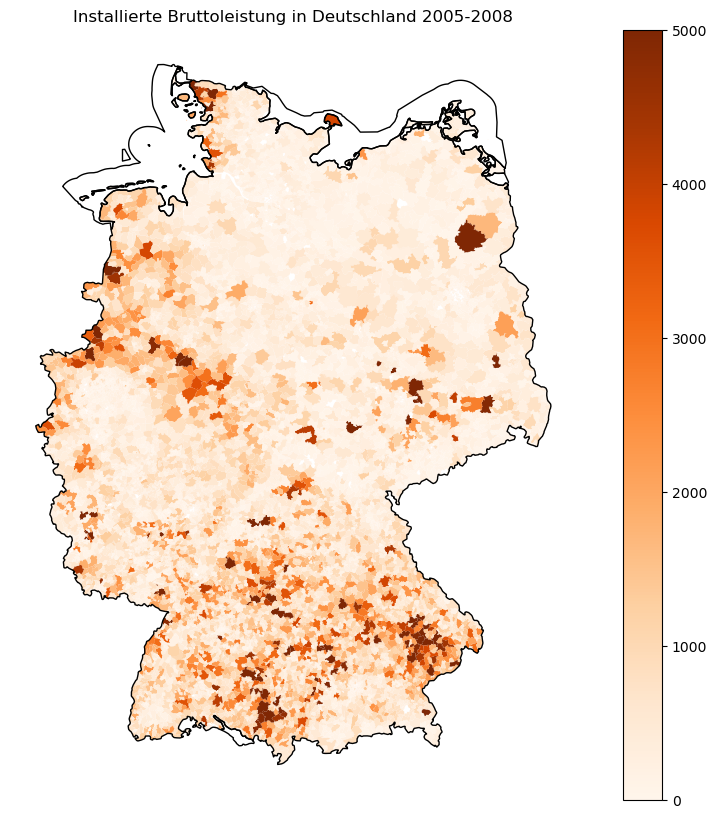

In [52]:
# gdf mit Tabelle leistung mergen
gdf1 = gdf.merge(leistung, left_on='name', right_on='Postleitzahl')

# Plot installierte Bruttoleistung
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ger_borders.boundary.plot(ax=ax, color='black', linewidth=1)
gdf1.plot(column='Bruttoleistung', cmap='Oranges', legend=True, ax=ax, vmin=0, vmax=5000)
ax.set_axis_off()
ax.set_title('Installierte Bruttoleistung in Deutschland 2005-2008')
plt.show()

### Plot 2: installierten Bruttoleistung 2009-2012

In [53]:
# Datenbank-Abfrage
query_17 = """
SELECT msd.Inbetriebnahmedatum,  msd.Postleitzahl, msd.Bruttoleistung
FROM marktstammdaten AS msd
WHERE strftime('%Y', msd.Inbetriebnahmedatum) BETWEEN '2009' AND '2012';
"""
abfrage_17 = pd.read_sql_query(query_17, con=con)
#abfrage_17

In [54]:
leistung2 = abfrage_17.groupby(['Postleitzahl'])['Bruttoleistung'].sum().reset_index()
leistung2

Postleitzahl  Bruttoleistung
0           01067         337.680
1           01069         606.935
2           01097         117.765
3           01099         689.520
4           01108         592.354
...           ...             ...
8100        99988         543.756
8101        99991        3368.585
8102        99994        6217.004
8103        99996         241.179
8104        99998        4778.138

[8105 rows x 2 columns]

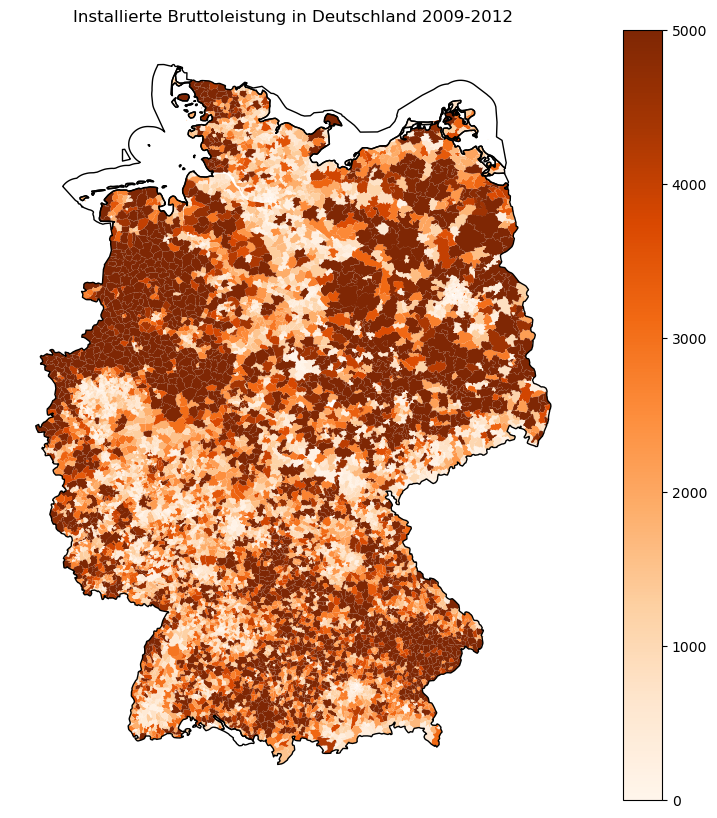

In [55]:
gdf2 = gdf.merge(leistung2, left_on='name', right_on='Postleitzahl')

# Plot installierte Bruttoleistung
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ger_borders.boundary.plot(ax=ax, color='black', linewidth=1)
gdf2.plot(column='Bruttoleistung', cmap='Oranges', legend=True, ax=ax, vmin=0, vmax=5000)
ax.set_axis_off()
ax.set_title('Installierte Bruttoleistung in Deutschland 2009-2012')
plt.show()

### Plot 3: installierten Bruttoleistung 2013-2018

In [56]:
# Datenbank-Abfrage
query_18 = """
SELECT msd.Inbetriebnahmedatum,  msd.Postleitzahl, msd.Bruttoleistung
FROM marktstammdaten AS msd
WHERE strftime('%Y', msd.Inbetriebnahmedatum) BETWEEN '2013' AND '2018';
"""
abfrage_18 = pd.read_sql_query(query_18, con=con)
#abfrage_18

In [57]:
leistung3 = abfrage_18.groupby(['Postleitzahl'])['Bruttoleistung'].sum().reset_index()
leistung3

Postleitzahl  Bruttoleistung
0           01067         252.750
1           01069         174.940
2           01097          46.003
3           01099         116.230
4           01108         280.095
...           ...             ...
8080        99988        1267.290
8081        99991         358.590
8082        99994        1136.600
8083        99996        5468.845
8084        99998        1096.765

[8085 rows x 2 columns]

In [58]:
#gdf mit Tabelle leistung mergen
gdf3 = gdf.merge(leistung3, left_on='name', right_on='Postleitzahl')

# Plot installierte Bruttoleistung
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ger_borders.boundary.plot(ax=ax, color='black', linewidth=1)
gdf3.plot(column='Bruttoleistung', cmap='Oranges', legend=True, ax=ax, vmin=0, vmax=5000)
ax.set_axis_off()
ax.set_title('Installierte Bruttoleistung in Deutschland 2013-2018')
plt.show()

### Plot 4: installierten Bruttoleistung 2019-2023

In [59]:
# Datenbank-Abfrage
query_19 = """
SELECT msd.Inbetriebnahmedatum,  msd.Postleitzahl, msd.Bruttoleistung
FROM marktstammdaten AS msd
WHERE strftime('%Y', msd.Inbetriebnahmedatum) BETWEEN '2019' AND '2023';
"""
abfrage_19 = pd.read_sql_query(query_19, con=con)
#abfrage_19

In [60]:
leistung4 = abfrage_19.groupby(['Postleitzahl'])['Bruttoleistung'].sum().reset_index()
leistung4

Postleitzahl  Bruttoleistung
0           01067         394.250
1           01069         994.975
2           01097         461.275
3           01099         983.715
4           01108       16627.161
...           ...             ...
8150        99988        1759.853
8151        99991        1958.400
8152        99994        6171.735
8153        99996        8863.515
8154        99998        2912.495

[8155 rows x 2 columns]

In [61]:
#gdf mit Tabelle leistung mergen
gdf4 = gdf.merge(leistung4, left_on='name', right_on='Postleitzahl')
# Plot installierte Bruttoleistung
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ger_borders.boundary.plot(ax=ax, color='black', linewidth=1)
gdf4.plot(column='Bruttoleistung', cmap='Oranges', legend=True, ax=ax, vmin=0, vmax=5000)
ax.set_title('Bruttoleistung in Deutschland')
ax.set_axis_off()
ax.set_title('Installierte Bruttoleistung in Deutschland 2019-2023')
plt.show()

### Plot 5: Installierte Bruttoleistung gesamt zwischen 2005 und 2023

In [62]:
# Datenbank-Abfrage
query_20 = """
SELECT msd.Inbetriebnahmedatum,  msd.Postleitzahl, msd.Bruttoleistung
FROM marktstammdaten AS msd
"""
abfrage_20 = pd.read_sql_query(query_20, con=con)
#abfrage_20

In [63]:
leistung5 = abfrage_20.groupby(['Postleitzahl'])['Bruttoleistung'].sum().reset_index()
leistung5

Postleitzahl  Bruttoleistung
0           01067        1092.910
1           01069        1830.365
2           01097         701.398
3           01099        1895.635
4           01108       17692.302
...           ...             ...
8155        99988        3784.659
8156        99991        5791.817
8157        99994       14107.879
8158        99996       14675.269
8159        99998        9051.059

[8160 rows x 2 columns]

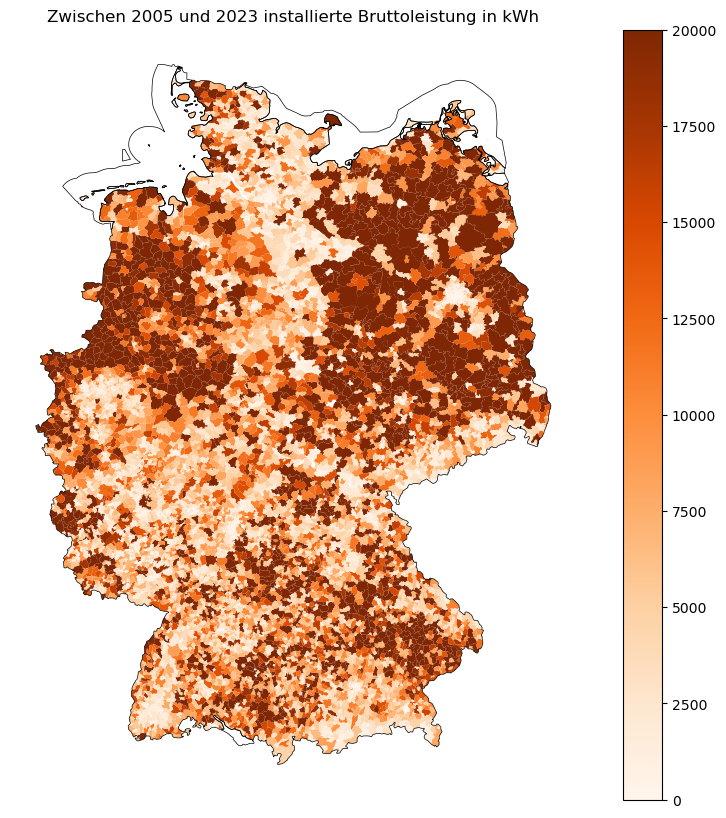

In [64]:
#gdf mit Tabelle leistung mergen
gdf5 = gdf.merge(leistung5, left_on='name', right_on='Postleitzahl')
# Plot installierte Bruttoleistung
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ger_borders.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf5.plot(column='Bruttoleistung', cmap='Oranges', legend=True, ax=ax, vmin=0, vmax=20000)
ax.set_title('Bruttoleistung in Deutschland')
ax.set_axis_off()
ax.set_title('Zwischen 2005 und 2023 installierte Bruttoleistung in kWh')
plt.show()

### Plot 6: Installierte Bruttoleistung gesamt zwischen 2005 und 2023  nach PLZ

In [65]:
# Datenbank-Abfrage
query_25 = """
SELECT msd.Inbetriebnahmedatum,  msd.Bundesland, msd.Bruttoleistung
FROM marktstammdaten AS msd
"""
abfrage_25 = pd.read_sql_query(query_25, con=con)
#abfrage_25

In [66]:
leistung6 = abfrage_25.groupby(['Bundesland'])['Bruttoleistung'].sum().reset_index()
leistung6

Bundesland  Bruttoleistung
0        Baden-Württemberg    9.587048e+06
1                   Bayern    2.108105e+07
2                   Berlin    2.448674e+05
3              Brandenburg    6.664551e+06
4                   Bremen    9.055026e+04
5                  Hamburg    1.057363e+05
6                   Hessen    3.619059e+06
7   Mecklenburg-Vorpommern    3.738120e+06
8            Niedersachsen    6.721980e+06
9      Nordrhein-Westfalen    9.210430e+06
10         Rheinland-Pfalz    3.843363e+06
11                Saarland    8.114290e+05
12                 Sachsen    3.262856e+06
13          Sachsen-Anhalt    4.174769e+06
14      Schleswig-Holstein    2.843289e+06
15               Thüringen    2.423419e+06

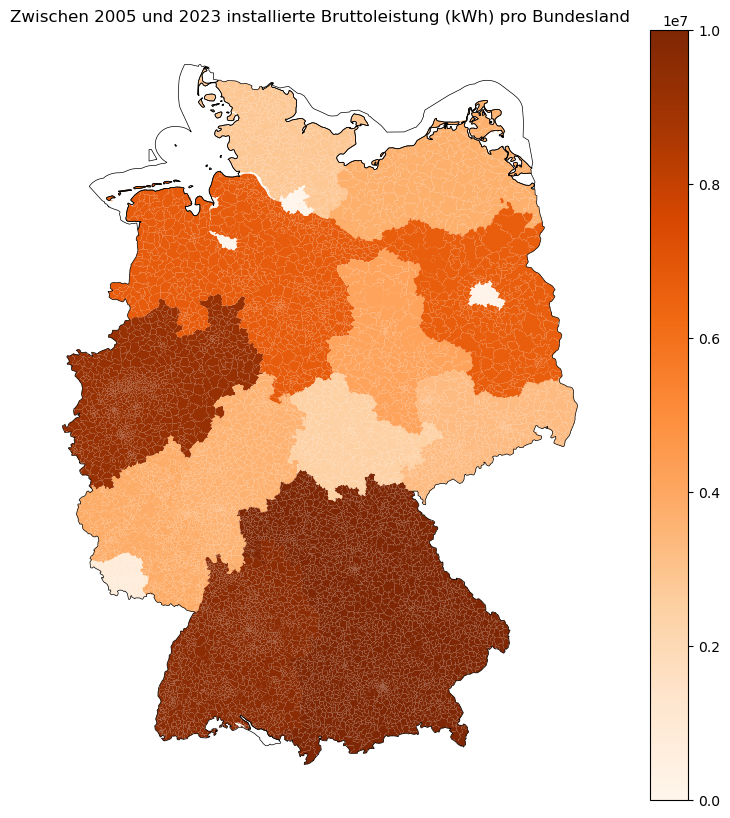

In [67]:
#gdf mit Tabelle leistung mergen
gdf6 = gdf.merge(leistung6, left_on='lan_name', right_on='Bundesland')
# Plot installierte Bruttoleistung
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ger_borders.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf6.plot(column='Bruttoleistung', cmap='Oranges', legend=True, ax=ax, vmin=0, vmax=10000000)
ax.set_title('Bruttoleistung in Deutschland')
ax.set_axis_off()
ax.set_title('Zwischen 2005 und 2023 installierte Bruttoleistung (kWh) pro Bundesland')
plt.show()

In [68]:
# Bundesländer Ranking
leistung6 = leistung6.sort_values('Bruttoleistung', ascending=False)
leistung6['Ranking'] = leistung6['Bruttoleistung'].rank(ascending=False).astype(int)
leistung6

Bundesland  Bruttoleistung  Ranking
1                   Bayern    2.108105e+07        1
0        Baden-Württemberg    9.587048e+06        2
9      Nordrhein-Westfalen    9.210430e+06        3
8            Niedersachsen    6.721980e+06        4
3              Brandenburg    6.664551e+06        5
13          Sachsen-Anhalt    4.174769e+06        6
10         Rheinland-Pfalz    3.843363e+06        7
7   Mecklenburg-Vorpommern    3.738120e+06        8
6                   Hessen    3.619059e+06        9
12                 Sachsen    3.262856e+06       10
14      Schleswig-Holstein    2.843289e+06       11
15               Thüringen    2.423419e+06       12
11                Saarland    8.114290e+05       13
2                   Berlin    2.448674e+05       14
5                  Hamburg    1.057363e+05       15
4                   Bremen    9.055026e+04       16

### Plot 7: Installierte Bruttoleistung pro 10.000 Einwohner nach PLZ (2005-2023)

In [69]:
# Datenbank-Abfrage
query_26 = """
SELECT
    msd.Bundesland,
    SUM(msd.Bruttoleistung) / bd.Bevölkerung * 10000 AS Bruttoleistung_pro_10k_Einwohner
FROM marktstammdaten AS msd
JOIN bevoelkerungsdichte AS bd ON msd.[AGS-5] = bd.[AGS-5]
GROUP BY msd.Bundesland
"""
abfrage_26 = pd.read_sql_query(query_26, con=con)
abfrage_26

Bundesland  Bruttoleistung_pro_10k_Einwohner
0        Baden-Württemberg                      3.043420e+05
1                   Bayern                      1.079834e+06
2                   Berlin                      6.658581e+02
3              Brandenburg                      4.017065e+05
4                   Bremen                      8.001048e+03
5                  Hamburg                      5.703344e+02
6                   Hessen                      1.161217e+05
7   Mecklenburg-Vorpommern                      1.587643e+05
8            Niedersachsen                      4.073088e+05
9      Nordrhein-Westfalen                      2.898978e+05
10         Rheinland-Pfalz                      3.131712e+05
11                Saarland                      4.189945e+04
12                 Sachsen                      1.342159e+05
13          Sachsen-Anhalt                      2.367548e+05
14      Schleswig-Holstein                      8.932003e+04
15               Thüringen                      1.136544e+05

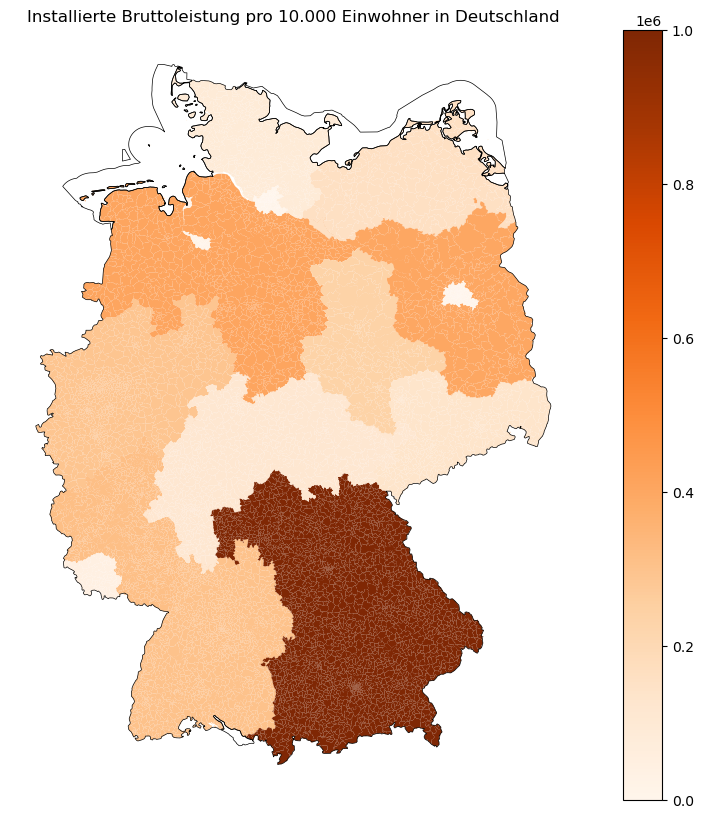

In [70]:
gdf7 = gdf.merge(abfrage_26, left_on='lan_name', right_on='Bundesland')
# Plot installierte Bruttoleistung pro 10.000 Einwohner
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ger_borders.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf7.plot(column='Bruttoleistung_pro_10k_Einwohner', cmap='Oranges', legend=True, ax=ax, vmin=0, vmax=1000000)
ax.set_title('Installierte Bruttoleistung pro 10.000 Einwohner in Deutschland')
ax.set_axis_off()
plt.show()

In [71]:
# Bundesländer Ranking
leistung7 = abfrage_26.sort_values('Bruttoleistung_pro_10k_Einwohner', ascending=False)
leistung7['Ranking'] = leistung7['Bruttoleistung_pro_10k_Einwohner'].rank(ascending=False).astype(int)
leistung7

Bundesland  Bruttoleistung_pro_10k_Einwohner  Ranking
1                   Bayern                      1.079834e+06        1
8            Niedersachsen                      4.073088e+05        2
3              Brandenburg                      4.017065e+05        3
10         Rheinland-Pfalz                      3.131712e+05        4
0        Baden-Württemberg                      3.043420e+05        5
9      Nordrhein-Westfalen                      2.898978e+05        6
13          Sachsen-Anhalt                      2.367548e+05        7
7   Mecklenburg-Vorpommern                      1.587643e+05        8
12                 Sachsen                      1.342159e+05        9
6                   Hessen                      1.161217e+05       10
15               Thüringen                      1.136544e+05       11
14      Schleswig-Holstein                      8.932003e+04       12
11                Saarland                      4.189945e+04       13
4                   Bremen                      8.001048e+03       14
2                   Berlin                      6.658581e+02       15
5                  Hamburg                      5.703344e+02       16

In [72]:
# Verbindung zur Datenbank trennen
con.close()